In [262]:
import scipy as sp
import numpy as np
import pandas as pd
import sklearn
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [263]:
# Importing the data
df = pd.read_csv('county_storage.csv')
# print(df.head(30))
# print(len(df))


df[df['location']=='CITY OF VERNON']

,Date,case_rate,cases,death_rate,deaths,location
79,04/15/2020,0,0,NaN,NaN,CITY OF VERNON
411,04/16/2020,0,0,NaN,NaN,CITY OF VERNON
743,04/17/2020,0,0,NaN,NaN,CITY OF VERNON
1075,04/18/2020,0,0,NaN,NaN,CITY OF VERNON
1407,04/19/2020,0,0,NaN,NaN,CITY OF VERNON
...,...,...,...,...,...,...
28697,07/19/2020,8134,17,0,0,CITY OF VERNON
29039,07/20/2020,8612,18,0,0,CITY OF VERNON
29381,07/21/2020,9569,20,0,0,CITY OF VERNON
29723,07/22/2020,9569,20,0,0,CITY OF VERNON


In [264]:
# median wage data

population = pd.read_csv('LA_County_Covid19_CSA_case_death_table.csv')
population = population[["geo_merge","population"]]
population = population.rename(columns={"geo_merge": "location"})
upper_loc=[]
for loc in population['location']:
    upper_loc.append(loc.upper())
population['location']=upper_loc

merged = df.merge(population, left_on="location", right_on="location", how="outer")


merged[merged['Date']=='05/29/2020']['population'].isnull().sum()
#There are 9 locations where population is null

9

In [265]:
# Let's look at each columns closer to find if there are any more null values.
null_each_col={}

for col in merged.columns:
    null_count=merged[col].isnull().sum()
    null_each_col[col]=null_count
print(null_each_col)

# There are no null values in 'Date', 'case_rate', ' cases', and 'location' column. 
# There are 9512 null values in 'death_rate' and 'deaths' column
# Those null values could mean either 0 deaths or unknown amount of death count.

{'Date': 0, 'case_rate': 0, 'cases': 0, 'death_rate': 9512, 'deaths': 9512, 'location': 0, 'population': 795}


In [266]:
# Date/Time Cleaning

date_format="%m/%d/%Y"

new_date_format=[]
for date in merged['Date']:
    date_new=dt.datetime.strptime(date,date_format)
    new_date_format.append(date_new)

merged['Date']=new_date_format
print(merged.head())



        Date case_rate cases death_rate deaths              location  \
0 2020-04-15    100.56    21        NaN    NaN  CITY OF AGOURA HILLS   
1 2020-04-16    105.35    22        NaN    NaN  CITY OF AGOURA HILLS   
2 2020-04-17    105.35    22        NaN    NaN  CITY OF AGOURA HILLS   
3 2020-04-18    114.93    24        NaN    NaN  CITY OF AGOURA HILLS   
4 2020-04-19    114.93    24        NaN    NaN  CITY OF AGOURA HILLS   

   population  
0     20883.0  
1     20883.0  
2     20883.0  
3     20883.0  
4     20883.0  


In [267]:
# Cleaning location names by removing unnecessary naming convention

string1='CITY OF '
location=merged['location']
merged['location']=merged['location'].str.replace(string1,'')

string3='UNINCORPORATED - '
merged['location']=merged['location'].str.replace(string3,'')
merged['location']=merged['location'].str.replace('*','') #some location names have symbol *

# Removing repeated location names
merged.drop_duplicates(subset=['location','Date'],keep='first',inplace=True)
print(merged[merged['location']=='AZUSA'][['Date','cases']].head(20))

          Date cases
444 2020-04-15    22
445 2020-04-16    22
446 2020-04-17    22
447 2020-04-18    22
448 2020-04-19    22
449 2020-04-21    31
450 2020-04-22    37
451 2020-04-23    40
452 2020-04-24    45
453 2020-04-27    55
454 2020-04-28    61
455 2020-04-29    68
456 2020-04-30    69
457 2020-05-01    71
458 2020-05-04    79
459 2020-05-05    83
460 2020-05-06    89
461 2020-05-07    96
462 2020-05-08    96
463 2020-05-09   101


In [268]:
# Some rows have -- as values. Those values will be changed to null values
merged=merged.replace('--',np.nan)

# Let's look at each columns closer to find if there are any more null values.
null_each_col={}

for col in merged.columns:
    null_count=merged[col].isnull().sum()
    null_each_col[col]=null_count
print(null_each_col)

{'Date': 0, 'case_rate': 413, 'cases': 413, 'death_rate': 8996, 'deaths': 8996, 'location': 0, 'population': 694}


In [269]:
# Converting object columns to float data type
col_names=['cases','case_rate','deaths','death_rate']

print(len(merged))
merged=merged[merged['cases'].str.isnumeric()==True]
merged[col_names]=merged[col_names].astype(float)
merged=merged.dropna(axis=0,subset=['cases'])

merged.info()


28713
<class 'pandas.core.frame.DataFrame'>
Int64Index: 28236 entries, 0 to 30326
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        28236 non-null  datetime64[ns]
 1   case_rate   28236 non-null  float64       
 2   cases       28236 non-null  float64       
 3   death_rate  19656 non-null  float64       
 4   deaths      19656 non-null  float64       
 5   location    28236 non-null  object        
 6   population  27606 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 1.7+ MB


In [270]:
# dropping cities with null population values
merged=merged.dropna(subset=['population'])

# checking if all null values are omitted
for col in merged.columns:
    null_count=merged[col].isnull().sum()
    null_each_col[col]=null_count
print(null_each_col)


only_LA_counties=merged[merged['location'].str.contains('LOS ANGELES -')]
print(only_LA_counties.head())
only_LA_counties[only_LA_counties['Date']=='2020-04-15']

{'Date': 0, 'case_rate': 0, 'cases': 0, 'death_rate': 8391, 'deaths': 8391, 'location': 0, 'population': 0}
           Date  case_rate  cases  death_rate  deaths  \
7653 2020-04-15     195.07   16.0         NaN     NaN   
7654 2020-04-16     195.07   16.0         NaN     NaN   
7655 2020-04-17     195.07   16.0         NaN     NaN   
7656 2020-04-18     195.07   16.0         NaN     NaN   
7657 2020-04-19     195.07   16.0         NaN     NaN   

                           location  population  
7653  LOS ANGELES - ADAMS-NORMANDIE      8202.0  
7654  LOS ANGELES - ADAMS-NORMANDIE      8202.0  
7655  LOS ANGELES - ADAMS-NORMANDIE      8202.0  
7656  LOS ANGELES - ADAMS-NORMANDIE      8202.0  
7657  LOS ANGELES - ADAMS-NORMANDIE      8202.0  


,Date,case_rate,cases,death_rate,deaths,location,population
7653,2020-04-15,195.07,16.0,NaN,NaN,LOS ANGELES - ADAMS-NORMANDIE,8202.0
7742,2020-04-15,56.25,7.0,NaN,NaN,LOS ANGELES - ALSACE,12445.0
7920,2020-04-15,98.92,34.0,NaN,NaN,LOS ANGELES - ARLETA,34370.0
8009,2020-04-15,61.37,9.0,NaN,NaN,LOS ANGELES - ATWATER VILLAGE,14666.0
8098,2020-04-15,109.24,34.0,NaN,NaN,LOS ANGELES - BALDWIN HILLS,31125.0
...,...,...,...,...,...,...,...
19490,2020-04-15,66.43,24.0,NaN,NaN,LOS ANGELES - WHOLESALE DISTRICT,36129.0
19579,2020-04-15,70.81,40.0,NaN,NaN,LOS ANGELES - WILMINGTON,56487.0
19668,2020-04-15,107.63,54.0,NaN,NaN,LOS ANGELES - WILSHIRE CENTER,50170.0
19757,2020-04-15,106.21,55.0,NaN,NaN,LOS ANGELES - WINNETKA,51786.0


In [271]:

col_name_percentage=['cases','case_percentage','deaths','death_percentage']
merged['case_percentage']=merged['cases']*100/merged['population']
merged['death_percentage']=merged['deaths']*100/merged['population']



In [272]:
# total_sum function will either sum data of all cities or all counties in LA
def total_sum(col_name,only_LA):
    dates=[]
    sums=[]
    if col_name == 'cases' or col_name=='deaths':
        if only_LA:
            only_LA_counties=merged[merged['location'].str.contains('LOS ANGELES -')]
            for date in sorted(merged['Date'].unique()):
                dates.append(date)
                sum_by_date=only_LA_counties[only_LA_counties['Date']==date][col_name].sum()
                sums.append(sum_by_date)
        else:    
            for date in sorted(merged['Date'].unique()):
                dates.append(date)
                sum_by_date=merged[merged['Date']==date][col_name].sum()
                sums.append(sum_by_date)
    else:
        if only_LA:
            only_LA_counties=merged[merged['location'].str.contains('LOS ANGELES -')]
            for date in sorted(merged['Date'].unique()):
                dates.append(date)
                sum_by_date=only_LA_counties[only_LA_counties['Date']==date][col_name].mean()
                sums.append(sum_by_date)
        else:    
            for date in sorted(merged['Date'].unique()):
                dates.append(date)
                sum_by_date=merged[merged['Date']==date][col_name].mean()
                sums.append(sum_by_date)
    return dates,sums

# county_sum will be used when pulling data of a specific city or LA county
def county_sum(col_name,county_name):
    dates=merged[merged['location']==county_name]['Date']
    sums=merged[merged['location']==county_name][col_name]
    return dates,sums


In [273]:
# plot_covid function plots either trend for all LA counties or a specific county

def plot_covid(all_or_county_name,perc_or_rate):
    
    fig=plt.figure(figsize=(12,12))
    if perc_or_rate=='percentage':
        col_plot_names_sum=['Total Cases','Case Percentage','Total Deaths','Death Percentage']
        col_plot_names_ind=['Cases','Case Percentage','Deaths','Death Percentage']
        y_label=['Cases',' Percentage','Deaths','Percentage']
        col_names=['cases','case_percentage','deaths','death_percentage']
    elif perc_or_rate=='rate':
        col_plot_names_sum=['Total Cases','Avg Case Rate','Total Deaths','Avg Death Rate']
        col_plot_names_ind=['Cases','Case Rate','Deaths','Death Rate']
        y_label=['Cases',' Rate Per 100,000 Resident','Deaths','Rate Per 100,000 Resident']
        col_names=['cases','case_rate','deaths','death_rate']
    i=1
    min_date=min(merged['Date'].unique())
    max_date=max(merged['Date'].unique())
    if all_or_county_name == 'all': #if given all, then return sum of all counties 
        for col in col_names:
            dates,sums=total_sum(col,False)
            ax=fig.add_subplot(2,2,i)
            ax.plot(dates,sums)
            ax.set_title('%s'%col_plot_names_sum[i-1],fontsize = 14)
            ax.set(xlabel='Date', ylabel='%s'%y_label[i-1])
            ax.set_xlim([min_date, max_date])
            ax.tick_params(labelrotation=45)
            ax.spines['top'].set_color('none')
            ax.spines['right'].set_color('none')
            ax.axvspan(*mdates.datestr2num(['05/07/2020', '06/05/2020']), color='red', alpha=0.2) # Stage 2 Reopening
            ax.axvspan(*mdates.datestr2num(['06/05/2020', '07/07/2020']), color='blue', alpha=0.1) # Stage 3 Reopening
            ax.axvspan(*mdates.datestr2num(['07/03/2020', '07/06/2020']), color='green', alpha=0.3) # Green = July 4th Weekend
            ax.axvspan(*mdates.datestr2num(['07/07/2020', '07/23/2020']), color='yellow', alpha=0.3) # Yellow = Indoor business reclosure order
            i+=1
    elif all_or_county_name == 'only_LA':
        for col in col_names:
            dates,sums=total_sum(col,True)
            ax=fig.add_subplot(2,2,i)
            ax.plot(dates,sums)
            ax.set_title('%s'%col_plot_names_sum[i-1],fontsize = 14)
            ax.set(xlabel='Date', ylabel='%s'%y_label[i-1])
            ax.set_xlim([min_date, max_date])
            ax.tick_params(labelrotation=45)
            ax.spines['top'].set_color('none')
            ax.spines['right'].set_color('none')
            ax.axvspan(*mdates.datestr2num(['05/07/2020', '06/05/2020']), color='red', alpha=0.2) # Stage 2 Reopening
            ax.axvspan(*mdates.datestr2num(['06/05/2020', '07/07/2020']), color='blue', alpha=0.1) # Stage 3 Reopening
            ax.axvspan(*mdates.datestr2num(['07/03/2020', '07/06/2020']), color='green', alpha=0.3) # Green = July 4th Weekend
            ax.axvspan(*mdates.datestr2num(['07/07/2020', '07/23/2020']), color='yellow', alpha=0.3) # Yellow = Indoor business reclosure order
            i+=1
    else:
        for col in col_names: #if given a specific name, then return plots for the specific county
            dates,sums=county_sum(col,all_or_county_name)
            ax=fig.add_subplot(2,2,i)
            ax.plot(dates,sums)
            ax.set_title('%s'%col_plot_names_ind[i-1],fontsize = 14)
            ax.set(xlabel='Date', ylabel='%s'%y_label[i-1])
            ax.set_xlim([min_date, max_date])
            ax.tick_params(labelrotation=45)
            ax.spines['top'].set_color('none')
            ax.spines['right'].set_color('none')
            ax.axvspan(*mdates.datestr2num(['05/07/2020', '06/05/2020']), color='red', alpha=0.2) # Stage 2 Reopening
            ax.axvspan(*mdates.datestr2num(['06/05/2020', '07/07/2020']), color='blue', alpha=0.1) # Stage 3 Reopening
            ax.axvspan(*mdates.datestr2num(['07/03/2020', '07/06/2020']), color='green', alpha=0.3) # Green = July 4th Weekend
            ax.axvspan(*mdates.datestr2num(['07/07/2020', '07/23/2020']), color='yellow', alpha=0.3) # Yellow = Indoor business reclosure order
            i+=1
    plt.tight_layout()
    ax.annotate('Reopen:\nStage 2', xy=(168, 550), xycoords='figure pixels',alpha=0.5,fontsize = 14)
    ax.annotate('Reopen:\nStage 3', xy=(280, 550), xycoords='figure pixels',alpha=0.5,fontsize = 14)   
    ax.annotate('Re-closure', xy=(370, 550), xycoords='figure pixels',alpha=0.5,fontsize = 14)
    ax.annotate('July 4th Weekend',
            xy=(350, 720), xycoords='figure pixels',
            xytext=(200, 800), textcoords='figure pixels',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')

In [274]:
merged['location'].unique()

array(['AGOURA HILLS', 'ALHAMBRA', 'ARCADIA', 'ARTESIA', 'AVALON',
       'AZUSA', 'BALDWIN PARK', 'BELL', 'BELL GARDENS', 'BELLFLOWER',
       'BEVERLY HILLS', 'BRADBURY', 'BURBANK', 'CALABASAS', 'CARSON',
       'CERRITOS', 'CLAREMONT', 'COMMERCE', 'COMPTON', 'COVINA', 'CUDAHY',
       'CULVER CITY', 'DIAMOND BAR', 'DOWNEY', 'DUARTE', 'EL MONTE',
       'EL SEGUNDO', 'GARDENA', 'GLENDALE', 'GLENDORA',
       'HAWAIIAN GARDENS', 'HAWTHORNE', 'HERMOSA BEACH', 'HIDDEN HILLS',
       'HUNTINGTON PARK', 'INDUSTRY', 'INGLEWOOD', 'IRWINDALE',
       'LA CANADA FLINTRIDGE', 'LA HABRA HEIGHTS', 'LA MIRADA',
       'LA PUENTE', 'LA VERNE', 'LAKEWOOD', 'LANCASTER', 'LAWNDALE',
       'LOMITA', 'LYNWOOD', 'MALIBU', 'MANHATTAN BEACH', 'MAYWOOD',
       'MONROVIA', 'MONTEBELLO', 'MONTEREY PARK', 'NORWALK', 'PALMDALE',
       'PALOS VERDES ESTATES', 'PARAMOUNT', 'PICO RIVERA', 'POMONA',
       'RANCHO PALOS VERDES', 'REDONDO BEACH', 'ROLLING HILLS',
       'ROLLING HILLS ESTATES', 'ROSEMEAD', 'SAN 

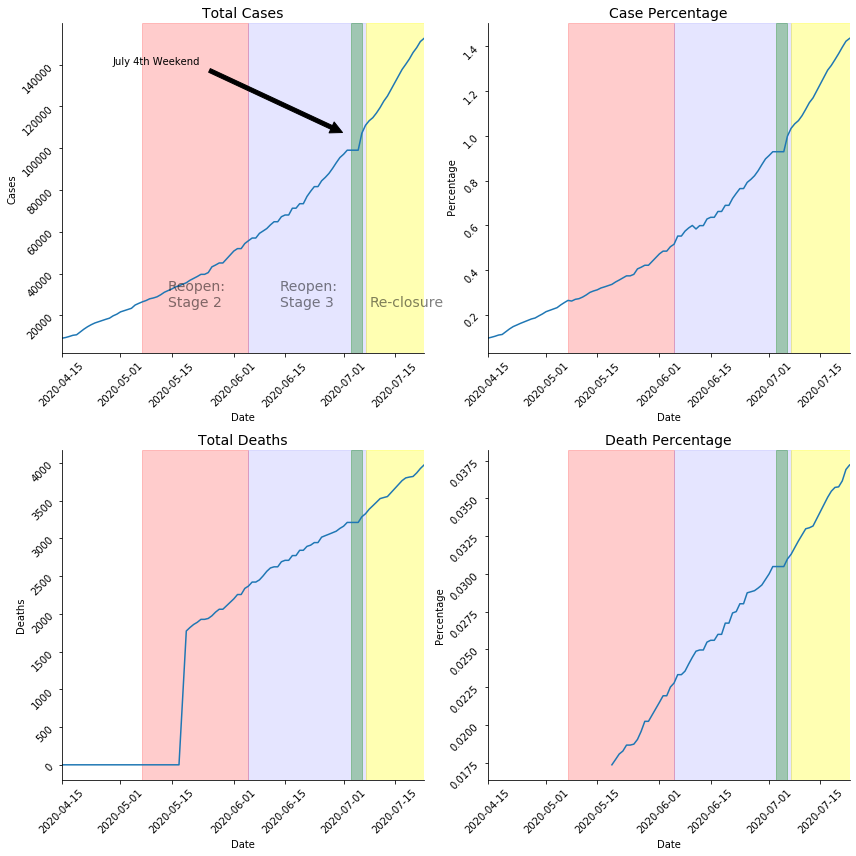

In [275]:
# Let's first look into all of the data together

plot_covid('all','percentage')

# Few things to note:
# All data is increasing, because all of those data are culmulative. It is impossible to have negative slope. Recovered cases doesn't get subtracted from the count.
# As the arrow annotation points out, no additional cases or deaths data were collected during Independece weekend.
# While slope of the deaths and death rate remains relatively constant, slope of the cases and case rate is increasing overtime.
# This means that infection rate is rising but percentage of patient dying is decreasing. Great News!
# Lastly, I have colored plots into four different regions: Reopen: Stage 2, Reopen: Stage 3, July 4th Weekend, and Reclosure
# Need more analysis, but it looks like there is a significant slope increase during 'Reopen: Stage 3'

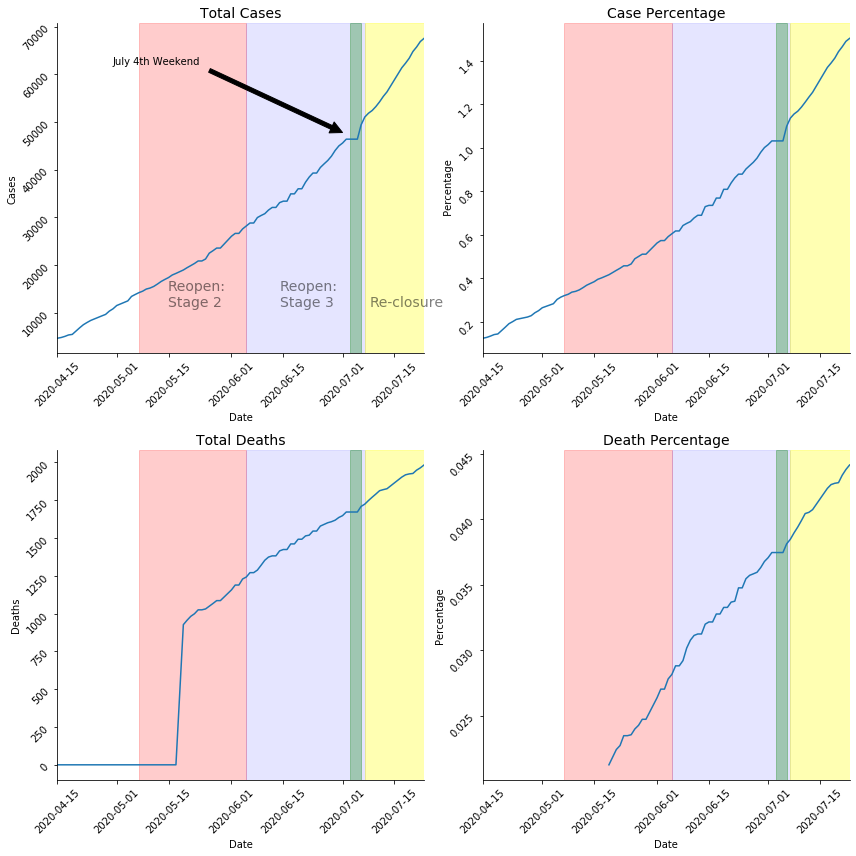

In [282]:
# Now, let's take a look at LA counties (which excludes adjacent cities)
# Since a large proportion of the samples overlap, there is no significant differnece shown.

plot_covid('only_LA','percentage')



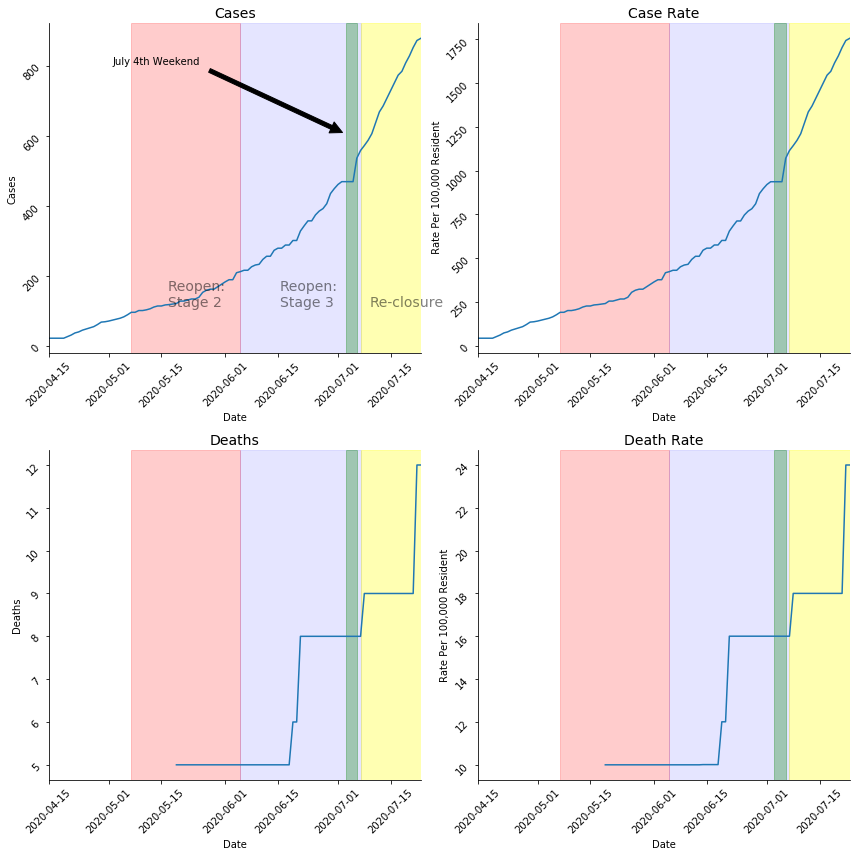

In [277]:
# Now let's take a closer look at individual counties.
# Here is city of Azusa:

plot_covid('AZUSA','rate')

# Data from Azusa shows clearer difference in four different stages. Stage 2 has relatively flat slope of cases, and case rate
# All of the categories, cases, case rate, deaths, death rate, jumps during Stage 3 and the slope is even worse after Re-closure.


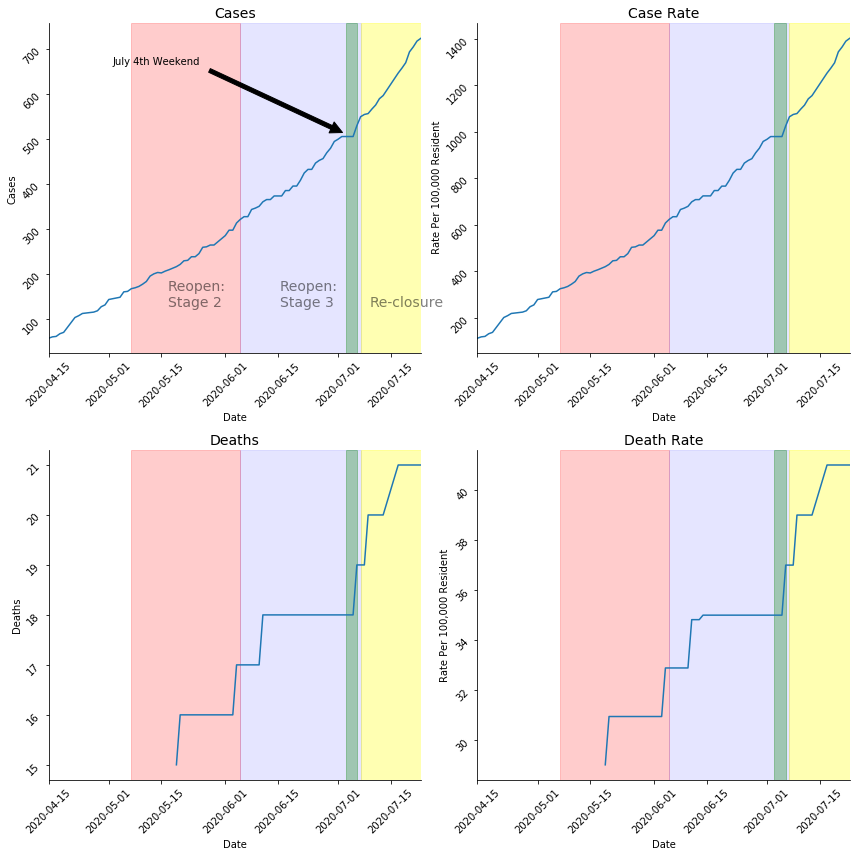

In [278]:
plot_covid('LOS ANGELES - KOREATOWN','rate')

In [279]:
# Now let's take a look at the city with the highest case rate.

newest_case_rate=merged[merged['Date']=='2020-07-23'][['location','case_rate']]
max_case_rate=max(newest_case_rate['case_rate'])
highest_case_rate_city=newest_case_rate[newest_case_rate['case_rate']==max_case_rate]['location']
print(highest_case_rate_city)
merged[merged['location']=='VERNON']

# City of Vernon has extremely high case_rate of 9569 case per 100,000 people. 
# However, this data is flawed since the total popluation of the city is 118 (Wikipedia)


7118    VERNON
Name: location, dtype: object


,Date,case_rate,cases,death_rate,deaths,location,population,case_percentage,death_percentage
7030,2020-04-15,0.0,0.0,NaN,NaN,VERNON,209.0,0.000000,NaN
7031,2020-04-16,0.0,0.0,NaN,NaN,VERNON,209.0,0.000000,NaN
7032,2020-04-17,0.0,0.0,NaN,NaN,VERNON,209.0,0.000000,NaN
7033,2020-04-18,0.0,0.0,NaN,NaN,VERNON,209.0,0.000000,NaN
7034,2020-04-19,0.0,0.0,NaN,NaN,VERNON,209.0,0.000000,NaN
...,...,...,...,...,...,...,...,...,...
7114,2020-07-19,8134.0,17.0,0.0,0.0,VERNON,209.0,8.133971,0.0
7115,2020-07-20,8612.0,18.0,0.0,0.0,VERNON,209.0,8.612440,0.0
7116,2020-07-21,9569.0,20.0,0.0,0.0,VERNON,209.0,9.569378,0.0
7117,2020-07-22,9569.0,20.0,0.0,0.0,VERNON,209.0,9.569378,0.0


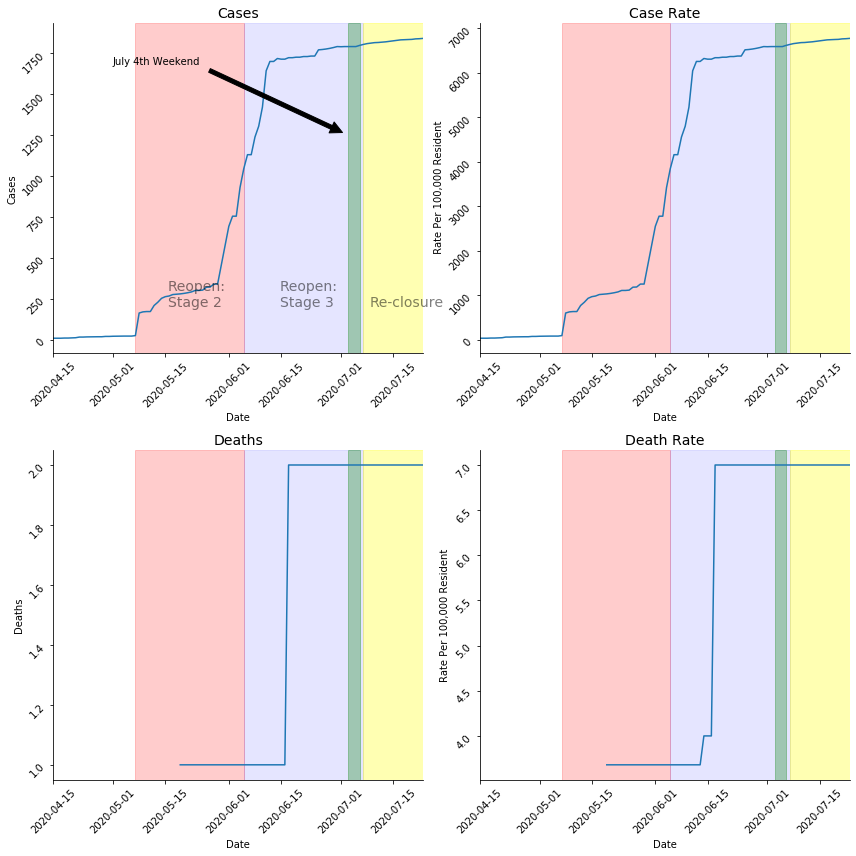

In [280]:
# According to the LA County Public Health website (http://publichealth.lacounty.gov/media/Coronavirus/locations.htm),
# I have found that the area with the highest case rate is Castaic. Let's take a closer look at the city data.

plot_covid('CASTAIC','rate')

# From the plots, an signifantly high jump in cases is shown in the area.
# However, exteremly low values of deaths and death rate is reported.
# From further research online, I have found out that most of the cases have occurred in Pitchess Detention Center.
# The center holds approximately 8,600 people on dention in addition to unknown amount of employees.
# This data shows how Covid 19 is more easily spread in closed and highly populated indoor enviroment.

13170    LOS ANGELES - LITTLE ARMENIA
Name: location, dtype: object


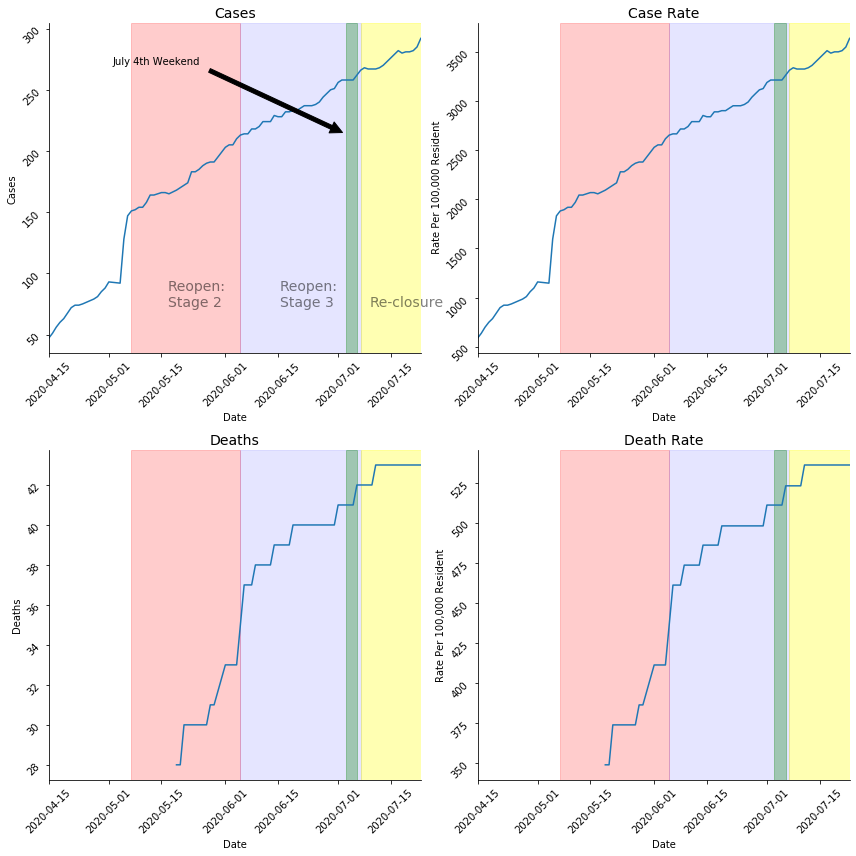

In [281]:
# Now let's take a look at the city with the highest death rate.

newest_death_rate=merged[merged['Date']=='2020-07-23'][['location','death_rate']]
max_death_rate=max(newest_death_rate['death_rate'])
highest_death_rate_city=newest_death_rate[newest_death_rate['death_rate']==max_death_rate]['location']

print(highest_death_rate_city)

plot_covid('LOS ANGELES - LITTLE ARMENIA','rate')

# This county has a distinct trend. There is a spike in the case before reopening stage 2 and slope of the case and case rate is steady after that
# Proportion of deaths against total case is extremely high ~14%.
# From the research, I have found out that Little Armenia is extremly population dense area.
# According to city-data.com, this community has 30,482 people per square mile, which LA average is 8,477 people per square mile.
